In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter
import scanpy as sc
import anndata as an
import sys
sys.path.append('code/scycle/')
import scycle as cc
import os
import pertpy as pt
import gc

import seaborn as sns

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

    
def preprocessing_without_pooling(adata,
                                  Normalize_Totals=True,
                                  top_variable_genes=10000,
                                  Already_Log_Transformed=False,
                                  number_of_pcs=30):
    if Normalize_Totals:
        sc.pp.normalize_total(adata, target_sum=10000)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig,
                      n_neighbours_for_pooling=10,
                      number_of_pcs=30):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
        anndata.obs[key] = scores
    return scores_dic

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic


def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def _compute_ica(adata,thr=2.0):
    adata.uns["scycle"] = {}
    cc.tl.dimensionality_reduction(adata,method='ica',find_cc_comp_thr=thr)

    idx_g1s = adata.uns['scycle']['find_cc_components']['indices']['G1-S']
    adata.uns['S-phase_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g1s,:]>3])
    idx_g2m = adata.uns['scycle']['find_cc_components']['indices']['G2-M']
    adata.uns['G2-M_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m,:]>3])
    #idx_g2m_inh = adata.uns['scycle']['find_cc_components']['indices']['G2-M-']
    #adata.uns['G2-M_INH_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m_inh,:]>3])
    #idx_histone = adata.uns['scycle']['find_cc_components']['indices']['Histone']
    #adata.uns['Histone_IC_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_histone,:]>3])
    signature_dict = {'S-phase':adata.uns['S-phase_genes'],
                      'G2-M':adata.uns['G2-M_genes'],
                      #'G2-M-':adata.uns['G2-M_INH_genes'],
                      #'Histone_IC':adata.uns['Histone_IC_genes']
                      }  
    sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
    ind_genes2k = np.where(adata.var['highly_variable'])[0]
    adata2k = adata[:,ind_genes2k]
    scores_dic = calc_scores(adata2k,signature_dict)
    for score in scores_dic:
        adata.obs[score] = scores_dic[score]
    adata.varm['P_dimRed'] = adata.uns['dimRed'].S_.T
    adata.uns['dimRed'] = None

def copy_celldrug_dataset(cell_line, drug, folder):
    code = os.system(f'gsutil cp "gs://tahoe100m_bycelllines/panel_cell_drug/*{cell_line}_{drug}_*.h5ad" {folder}')
    adata_cellline = None
    if code==0:
        files = os.listdir(folder)
        h5s = []
        plates = []
        for i,f in enumerate(files):
            if (cell_line+'_'+drug+'_' in f)&(f.startswith('plate')):
                print(i+1,f)
                adata = sc.read_h5ad(folder+f)
                h5s.append(adata)
                plate = f.split('_')[0]
                plates.append(plate)
        for p in plates:
            os.system(f'gsutil cp gs://tahoe100m_bycelllines/panel_cell_drug/{p}_{cell_line}_DMSO_TF_0.0.h5ad {folder}')
            adata = sc.read_h5ad(folder+f'{p}_{cell_line}_DMSO_TF_0.0.h5ad')    
            h5s.append(adata)
        adata_cellline = sc.concat(h5s)
        for h in h5s:
            del h       
    else:
        print(f'ERROR: Could not download the files for {cell_line}, {drug}')
    return adata_cellline

def cellline_drug_file_preprocessing(adata_cellline,
    top_variable_genes = 10000, # if negative then no selection of genes
    Normalize_Totals = True,
    Already_Log_Transformed = False,
    n_neighbours_for_pooling = 5,
    number_of_pcs = 30):
    
    print('PREPROCESSING PARAMETERS:')
    print('Already_Log_Transformed=',Already_Log_Transformed)
    print('Normalize_Totals=',Normalize_Totals)
    print('number_of_pcs=',number_of_pcs)
    print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
    print('top_variable_genes=',top_variable_genes)
    
    if n_neighbours_for_pooling>0:
        adatat1 = pooling_procedure(adata_cellline,adata_cellline,
                                   number_of_pcs=number_of_pcs,
                                   n_neighbours_for_pooling=n_neighbours_for_pooling)
    else:
        adatat1 = adata_cellline
    adatat1 = preprocessing_without_pooling(adatat1,
                                      Normalize_Totals=True,
                                      top_variable_genes=10000,
                                      Already_Log_Transformed=False,
                                      number_of_pcs=30)
    return adatat1

def balance_control_measurement(adata_cellline):
    conds = np.unique(adata_cellline.obs['drugname_drugconc'])
    n_control = len(adata_cellline[adata_cellline.obs['drugname_drugconc']=="[('DMSO_TF', 0.0, 'uM')]"])
    print(f'{n_control=}')
    n_conds = []
    for cond in conds:
        if not cond=="[('DMSO_TF', 0.0, 'uM')]":
            n_cond = len(adata_cellline[adata_cellline.obs['drugname_drugconc']==cond])
            n_conds.append(n_cond)
    print(f'{n_conds=}')
    n_subs = np.max(np.array(n_conds))
    adata_control = adata_cellline[adata_cellline.obs['drugname_drugconc']=="[('DMSO_TF', 0.0, 'uM')]"]
    adata_control = sc.pp.sample(adata_control,fraction=float(n_subs)/float(n_control),copy=True)
    adatas = [adata_control]
    for cond in conds:
            if not cond=="[('DMSO_TF', 0.0, 'uM')]":
                adata_cond = adata_cellline[adata_cellline.obs['drugname_drugconc']==cond]
                adatas.append(adata_cond)
    adata_cellline = sc.concat(adatas)
    for a in adatas:
        del a
    gc.collect()
    return adata_cellline

def get_cellcycle_space(adata_cellline):
    cc_genes = list(set(cc.data.cc_genes))
    cc_genes = [g for g in cc_genes if g in adata_cellline.var_names]
    adata_cellline = adata_cellline[:,cc_genes]
    return adata_cellline

import ast
def compute_distance(adatat1,distance_type='edistance',plotheatmap=False,plotdistances=False):
    distance = pt.tl.Distance(distance_type, obsm_key="X_pca")
    df = distance.pairwise(adatat1, groupby='drugname_drugconc')
    if plotheatmap:
        sns.clustermap(df, robust=True, figsize=(10, 10))
        display(df)
    doses = []
    dists = []
    for c in df.columns:
        dose = ast.literal_eval(c)[0][1]
        #doses.append(-5.0 if dose==0 else np.log10(dose))
        doses.append(dose)
        dist = df.loc["[('DMSO_TF', 0.0, 'uM')]"][c].item()
        dists.append(dist)
    if plotdistances:
        df1 = pd.DataFrame({'logdose':doses,'edistance':dists})
        sns.scatterplot(df1,x='logdose',y='edistance',s=200)
        sns.lineplot(df1,x='logdose',y='edistance')
        plt.title(f'{cell_line},{drug}')
    return {d[0]:d[1] for d in zip(doses,dists)}

def compute_distance_sameplate_control(adatat1,distance_type='edistance',plotheatmap=False,plotdistances=False):
    distance = pt.tl.Distance(distance_type, obsm_key="X_pca")
    plates = np.unique(adatat1.obs['plate'])
    dss_dict = {}
    for p in plates:
        print(p)
        dss = compute_distance(adatat1[adatat1.obs['plate']==p,:], 
                               distance_type=distance_type,
                               plotheatmap=plotheatmap,
                              plotdistances=plotdistances)
        for k in dss:
            if k in dss_dict:
                dss_dict[k] = np.min([dss[k],dss_dict[k]])
            else:
                dss_dict[k] = dss[k]    
    return dss_dict


In [24]:
adatat1

AnnData object with n_obs × n_vars = 9529 × 10000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'G1S_regev', 'G2M_regev', 'S-phase', 'G2-M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'drugname_drugconc_colors', 'log1p', 'pca', 'scycle', 'dimRed', 'S-phase_genes', 'G2-M_genes', 'hvg'
    obsm: 'X_pca', 'X_dimRed', 'X_pca_scycle', 'X_cc'
    varm: 'PCs', 'P_dimRed'

In [29]:
folder = 'data/cellline_drug/'
#cell_line = 'CVCL_0023'
#cell_line = 'CVCL_0459'
cell_line = 'CVCL_1119'
#cell_line = 'CVCL_1731'
#cell_line = 'CVCL_C466'
#cell_line = 'CVCL_1517'
#drug = 'Docetaxel'
drug = 'Panobinostat'
#drug = '(R)-Verapamil (hydrochloride)'
#drug = 'Adagrasib'

In [ ]:
from guppy import hpy
h = hpy()
print(h.heap())


In [30]:
adata_cellline = copy_celldrug_dataset(cell_line,drug,folder)

genes_to_exclude = [g for g in adata_cellline.var_names if (g.startswith('MT-')|(g=='MALAT1'))]
print(f'{genes_to_exclude=}')
adata_cellline = adata_cellline[:,~adata_cellline.var_names.isin(genes_to_exclude)].copy()
    
adata_cellline.write_h5ad(folder+cell_line+'_'+drug+'.h5ad',compression='gzip')
display(adata_cellline)

Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate10_CVCL_1119_Panobinostat_0.05.h5ad...
Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate11_CVCL_1119_Panobinostat_0.5.h5ad...
Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate12_CVCL_1119_Panobinostat_5.0.h5ad...
\ [3 files][ 36.0 MiB/ 36.0 MiB]                                                
Operation completed over 3 objects/36.0 MiB.                                     


3 plate10_CVCL_1119_Panobinostat_0.05.h5ad
4 plate12_CVCL_1119_Panobinostat_5.0.h5ad
5 plate11_CVCL_1119_Panobinostat_0.5.h5ad


Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate10_CVCL_1119_DMSO_TF_0.0.h5ad...
/ [1 files][ 15.6 MiB/ 15.6 MiB]                                                
Operation completed over 1 objects/15.6 MiB.                                     
Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate12_CVCL_1119_DMSO_TF_0.0.h5ad...
/ [1 files][ 18.5 MiB/ 18.5 MiB]                                                
Operation completed over 1 objects/18.5 MiB.                                     
Copying gs://tahoe100m_bycelllines/panel_cell_drug/plate11_CVCL_1119_DMSO_TF_0.0.h5ad...
/ [1 files][ 14.7 MiB/ 14.7 MiB]                                                
Operation completed over 1 objects/14.7 MiB.                                     


genes_to_exclude=['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8', 'MALAT1']


AnnData object with n_obs × n_vars = 19980 × 62672
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [31]:
adata_cellline = sc.read_h5ad(folder+cell_line+'_'+drug+'.h5ad')
adata_cellline.X = adata_cellline.X.todense()
display(adata_cellline)

/home/zinovyev/tahoe/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.


AnnData object with n_obs × n_vars = 19980 × 62672
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [95]:
# Limit only to one plate
if False:
    adata_cellline = adata_cellline[adata_cellline.obs['plate']=='plate12',:]
    display(adata_cellline)

View of AnnData object with n_obs × n_vars = 6742 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [32]:
# balance control and measurement
if True:
    adata_cellline = balance_control_measurement(adata_cellline)

n_control=13025
n_conds=[2574, 2185, 2196]


In [15]:
# Limit only to cell cycle genes
if True:
    adata_cellline = get_cellcycle_space(adata_cellline)

PREPROCESSING PARAMETERS:
Already_Log_Transformed= False
Normalize_Totals= True
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


/home/zinovyev/tahoe/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:408: UserWarning: Received a view of an AnnData. Making a copy.
/home/zinovyev/tahoe/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:408: UserWarning: Received a view of an AnnData. Making a copy.


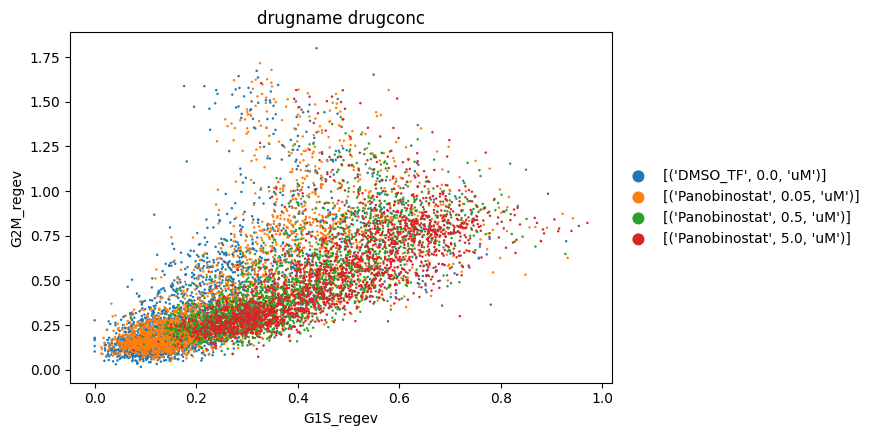

Finished.


In [33]:
adatat1 = cellline_drug_file_preprocessing(adata_cellline)
cc_regev = {'G1S_regev':cc.data._cc_markers.g1s_markers,
            'G2M_regev':cc.data._cc_markers.g2m_markers}
calc_scores(adatat1,cc_regev)
sc.pl.scatter(adatat1,x='G1S_regev',y='G2M_regev',color='drugname_drugconc')
adatat1.write_h5ad(folder+cell_line+'_'+drug+'_processed.h5ad',compression='gzip')
print('Finished.')

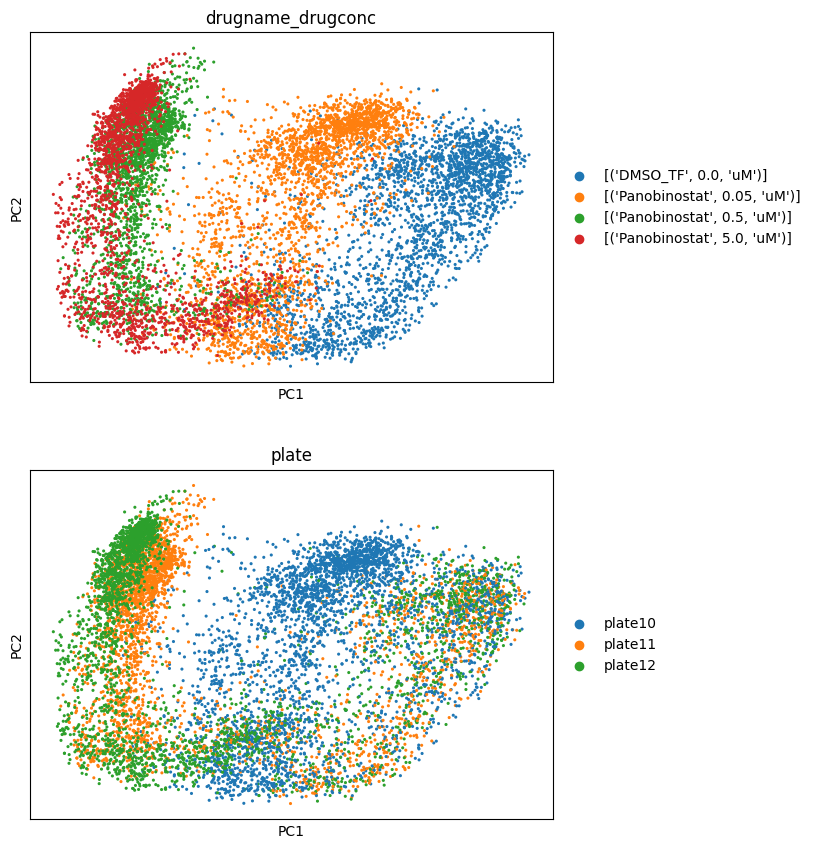

In [34]:
sc.pl.pca(
    adatat1,
    color=["drugname_drugconc","plate"],
    dimensions=[(0, 1), (0, 1)],
    ncols=1,
    size=20,
)

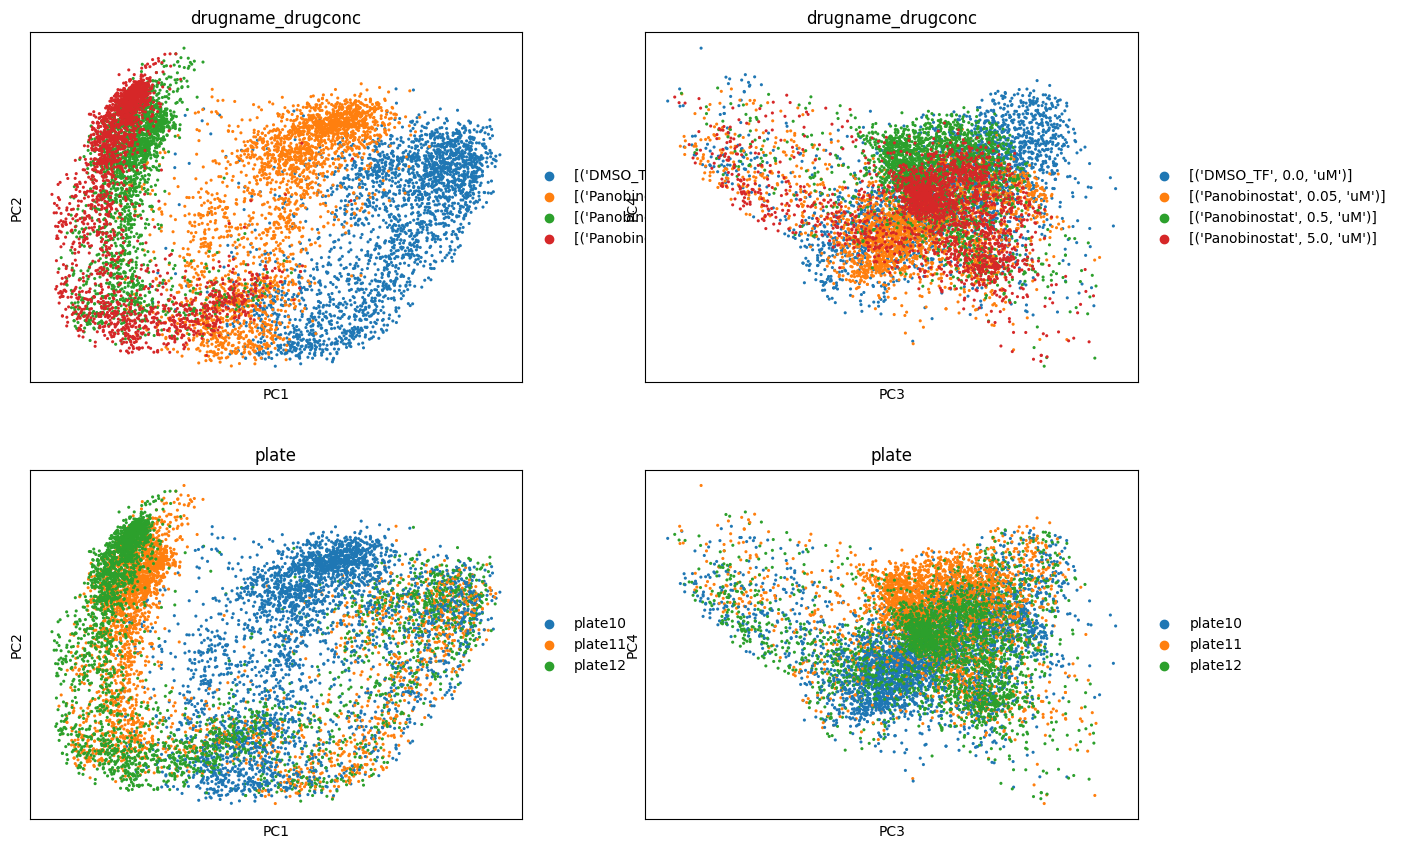

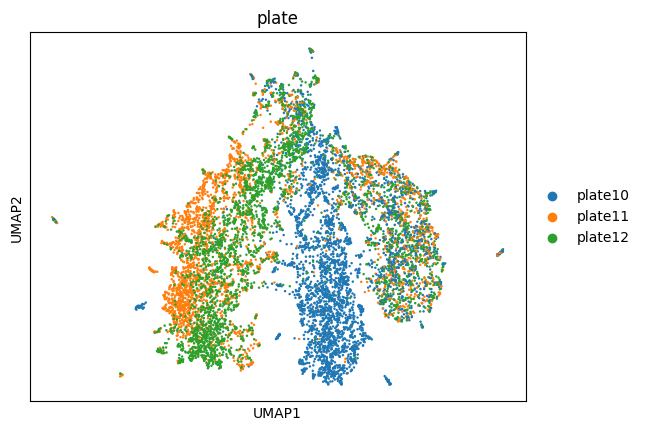

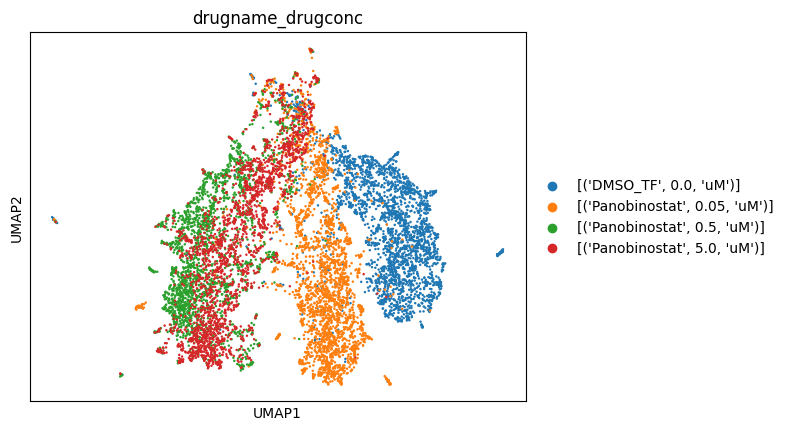

In [35]:
sc.tl.pca(adatat1)
sc.pl.pca(
    adatat1,
    color=["drugname_drugconc", "drugname_drugconc","plate","plate"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=20,
)
sc.pp.neighbors(adatat1,n_neighbors=10)
sc.tl.umap(adatat1)
sc.pl.umap(adatat1,color='plate')
sc.pl.umap(adatat1,color='drugname_drugconc')

In [5]:
adatat1 = sc.read_h5ad(folder+cell_line+'_'+drug+'_processed.h5ad')
adatat1

AnnData object with n_obs × n_vars = 9529 × 10000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'G1S_regev', 'G2M_regev'
    uns: 'drugname_drugconc_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
_compute_ica(adatat1,thr=0.4)
Smatrix = adatat1.varm['P_dimRed']
Amatrix = adatat1.obsm['X_dimRed']
Metasamples_df = pd.DataFrame(data=Amatrix)
Metasamples_df.index = adatat1.obs_names
Metasamples_df.columns = [f'IC{i+1}' for i in range(Smatrix.shape[1])]
Metasamples_adata = an.AnnData(Metasamples_df)
Metasamples_adata.uns['S-phase_genes'] = list(adatat1.uns['S-phase_genes'])
Metasamples_adata.uns['G2-M_genes'] = list(adatat1.uns['G2-M_genes'])
Metasamples_adata.obs['G1S_regev'] = list(adatat1.obs['G1S_regev'])
Metasamples_adata.obs['G2M_regev'] = list(adatat1.obs['G2M_regev'])
Metasamples_adata.uns['scycle'] = list(adatat1.uns['scycle'])
Metasamples_adata.uns['gene_means'] = np.mean(adatat1.X,axis=0)
Metasamples_adata.uns['Metagenes'] = Smatrix 
Metasamples_adata.write_h5ad(folder+cell_line+drug+'_ICA.h5ad',compression='gzip')
print('S-phase_genes',list(adatat1.uns['S-phase_genes']))
print('G2-M_genes',list(adatat1.uns['G2-M_genes']))

-- Dimensionality reduction using ICA...
-- Done
g1s_score=np.float64(1.7111324208354262) g2m_score=np.float64(6.45579124854664) g2mi_score=np.float64(0.6707995351188059) histone_score=np.float64(3.1538527738366717) thr=0.4
--- Selected components:
G1-S: 24 (score=1.711132)
G2-M: 0 (score=6.455791)
G2-M-: 16 (score=0.670800)
Histones: 6 (score=3.153853)


/tmp/ipykernel_7931/3670619240.py:126: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


S-phase_genes ['NEAT1', 'CXCL8', 'DTNA', 'MYO1E', 'SMYD3', 'ARHGAP26', 'PRKCA', 'LINC00511', 'EXT1', 'EFNA5', 'TANC2', 'RAD51B', 'ZSWIM6', 'AKAP13', 'HSPA8', 'GMDS', 'INSIG1', 'IER3', 'AGAP1', 'ZBTB20', 'MAPK8', 'SND1', 'PPP1R13B', 'FRMD5', 'EXOC6B', 'RCOR1', 'HPCAL1', 'LRPPRC', 'MCU', 'ADK', 'ISG15', 'HIVEP3', 'PVT1', 'ABTB3', 'COG5', 'EML4', 'TTLL5', 'FAF1', 'IMMP2L', 'MYO10', 'DAAM1', 'NCKAP5', 'APBB2', 'TYW1B', 'NALF1', 'XPR1', 'SPIDR', 'TBC1D8', 'RORA', 'PCBP3', 'SBF2', 'RAPGEF6', 'PRIM2', 'MGAT5', 'RRM2', 'PIAS1', 'FAM172A', 'SNX29', 'TASP1', 'CADM1', 'PRKDC', 'LMBR1', 'CMSS1', 'PPP6R3', 'PMEPA1', 'KIAA1328', 'TAF3', 'TRPM7', 'TFDP2', 'CDKAL1', 'SEC22A', 'RANBP17', 'USP37', 'VPS8', 'NBAS', 'STIL', 'SPG7', 'HELLS', 'SPATA5', 'MAP3K14', 'UBE3C', 'CEP128', 'HIBADH', 'PITPNB', 'DIAPH3', 'RNGTT', 'ENSG00000285016', 'FHOD3', 'INPP5A', 'PPP4R4', 'BRIP1', 'ATAD2', 'ACACA', 'NXN', 'RNF121', 'NUP160', 'POLA1', 'MIR924HG', 'CDC6', 'CDK1', 'NCAPG2', 'ACO1', 'RTTN', 'FANCB', 'NAA25', 'FANCM',

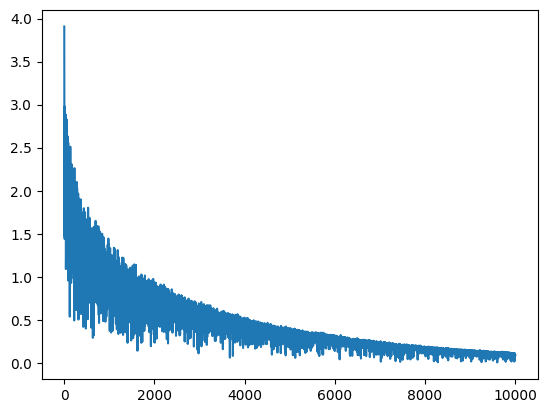

[3.9083865 3.2719896 2.4742525 2.304833  2.8357596 2.3927205 2.6289625
 2.9795682 2.493089  1.438729 ]
Index(['NEAT1', 'HSP90B1', 'ERO1A', 'HSPA5', 'PTMA', 'HSP90AA1', 'MT2A',
       'GAPDH', 'FNDC3B', 'CXCL8'],
      dtype='object', name='gene_name')


In [10]:
if True:
    mn = adatat1.X.mean(axis=0)
    plt.plot(mn)
    plt.show()
    print(mn[:10])
    print(adatat1.var_names[:10])

(9529, 10000)


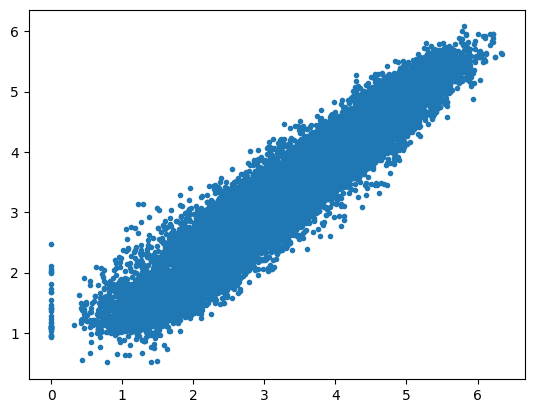

In [40]:
aex = Metasamples_adata
A = aex.X
S = aex.uns['Metagenes']
means = aex.uns['gene_means']
X = adatat1.X
Xt = A@S.T+means
print(Xt.shape)
xx = X[:,:3].ravel()
yy = Xt[:,:3].ravel()
plt.plot(xx,yy,'.')
plt.show()

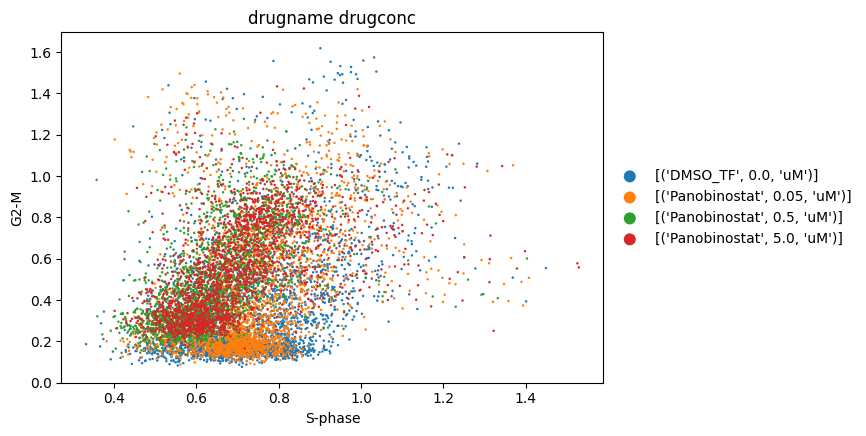

In [11]:
sc.pl.scatter(adatat1,x='S-phase',y='G2-M',color='drugname_drugconc')
#sc.pl.scatter(adatat1,x='S-phase',y='G2-M',color='plate')

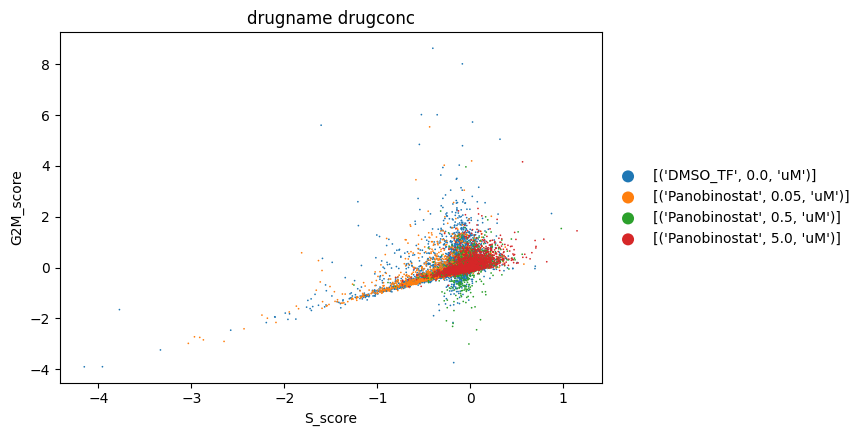

In [11]:
sc.pl.scatter(adatat1,x='S_score',y='G2M_score',color='drugname_drugconc')

In [12]:
print(adatat1[adatat1.obs['drugname_drugconc']=="[('DMSO_TF', 0.0, 'uM')]",:])
print(adatat1[adatat1.obs['drugname_drugconc']=="[('"+drug+"', 0.05, 'uM')]",:])
print(adatat1[adatat1.obs['drugname_drugconc']=="[('"+drug+"', 0.5, 'uM')]",:])
print(adatat1[adatat1.obs['drugname_drugconc']=="[('"+drug+"', 5.0, 'uM')]",:])

View of AnnData object with n_obs × n_vars = 13025 × 10000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'G1S_regev', 'G2M_regev', 'S-phase', 'G2-M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'drugname_drugconc_colors', 'log1p', 'pca', 'scycle', 'dimRed', 'S-phase_genes', 'G2-M_genes', 'hvg'
    obsm: 'X_pca', 'X_dimRed', 'X_pca_scycle', 'X_cc'
    varm: 'PCs', 'P_dimRed'
View of AnnData object with n_obs × n_vars = 2574 × 10000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'G1S_regev', 'G2M_regev', 'S-phase', 'G2-M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'drugname_drugconc_colors', 

In [15]:
%%capture
de = compute_distance_sameplate_control(adatat1,distance_type='edistance')
dw = compute_distance_sameplate_control(adatat1,distance_type='wasserstein')
dm = compute_distance_sameplate_control(adatat1,distance_type='mmd')
distances = {'edistance':de,'wassertein':dw,'mmd':dm}
with open(f'data/cellline_drug/{cell_line}_{drug}_distances.txt','w') as f:
    f.write(str(distances))

In [45]:
reference = "[('DMSO_TF', 0.0, 'uM')]"
plates = np.unique(adatat1.obs['plate'])
rgg_dict = {}
for p in plates:
    print(p)
    adatas = adatat1[adatat1.obs['plate']==p,:]
    sc.tl.rank_genes_groups(adatas, groupby="drugname_drugconc", 
                        reference=reference, method="wilcoxon")
    rgg_dict[p] = adatas.uns['rank_genes_groups']
with open(folder+cell_line+'_'+drug+'_signature.pkl', 'wb') as handle:
    pickle.dump(rgg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


plate10


/home/zinovyev/tahoe/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


plate11


/home/zinovyev/tahoe/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


plate12


/home/zinovyev/tahoe/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [20]:
df = pd.DataFrame(data=b['plate10']['scores'])
display(df)

,"[('Panobinostat', 0.05, 'uM')]"
0,38.266941
1,31.580900
2,31.434464
3,27.703005
4,25.914572
...,...
9995,-29.511171
9996,-30.040197
9997,-30.218786
9998,-32.324009


[('Panobinostat', 5.0, 'uM')]


,names,scores,logfoldchanges,pvals,pvals_adj
0,CRISPLD2,37.279999,4.582491,3.461758e-304,2.472685e-301
1,TYW1B,37.223999,3.438893,2.792193e-303,1.745121e-300
2,NOLC1,37.189007,2.602247,1.027481e-302,6.044004e-300
3,DNM3,36.425152,3.887517,1.702337e-290,7.093070e-288
4,XPR1,36.296139,2.232045,1.861588e-288,7.446350e-286
...,...,...,...,...,...
9995,MET,-39.212524,-2.306200,0.000000e+00,0.000000e+00
9996,SEMA4B,-39.770397,-2.420878,0.000000e+00,0.000000e+00
9997,FNDC3B,-40.046249,-2.017156,0.000000e+00,0.000000e+00
9998,CHD2,-40.400768,-2.092084,0.000000e+00,0.000000e+00


/home/zinovyev/tahoe/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


<Axes: xlabel='logfoldchanges', ylabel='logpval'>

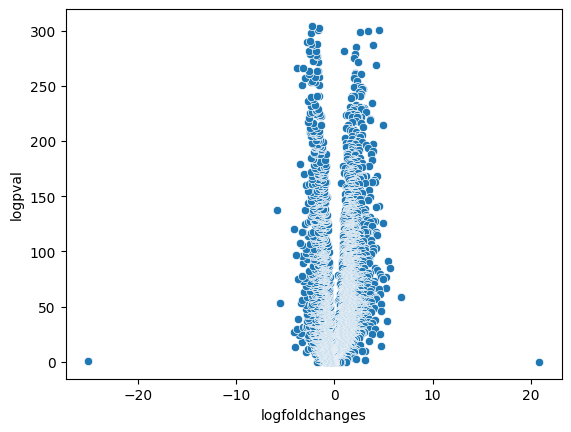

In [8]:
with open(folder+cell_line+'_'+drug+'.pkl', 'rb') as handle:
    b = pickle.load(handle)



group = "[('"+drug+"', 5.0, 'uM')]"
print(group)
df_ranks = sc.get.rank_genes_groups_df(adatas, group=group)
display(df_ranks)
df_ranks['logpval'] = -np.log10(df_ranks['pvals_adj'])
sns.scatterplot(df_ranks,x='logfoldchanges',y='logpval')

In [18]:
adatas.uns['rank_genes_groups']['names'].dtype.names

("[('Panobinostat', 5.0, 'uM')]",)

In [17]:
df_ranks.sort_values(by='logfoldchanges')

,names,scores,logfoldchanges,pvals,pvals_adj,logpval
7034,LINC02426,-1.380106,-25.043203,1.675539e-01,1.831390e-01,0.737219
9782,ENSG00000286546,-25.124409,-5.851027,2.691627e-139,5.437631e-138,137.264590
9279,LINC00278,-15.635550,-5.552984,4.168632e-55,1.963557e-54,53.706956
9709,OAS2,-23.518438,-4.123860,2.642042e-122,3.885356e-121,120.410569
8841,SERPINB3,-10.981506,-4.100752,4.690378e-28,1.238220e-27,26.907202
...,...,...,...,...,...,...
2047,MIR493HG,12.974364,5.311136,1.710084e-38,5.746251e-38,37.240615
676,TMEFF2,20.423277,5.420761,1.038602e-92,9.390614e-92,91.027306
752,NRXN2,19.776430,5.705436,4.751654e-87,3.923744e-86,85.406299
1264,TTC29,16.322573,6.757389,6.819992e-60,3.528190e-59,58.452448


In [31]:
result = adatas.uns['rank_genes_groups']
groups = result['names'].dtype.names
print(groups)
gene_signature = {
    group: pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals_adj': result['pvals_adj'][group]
    }) for group in groups
}

("[('DMSO_TF', 0.0, 'uM')]", "[('Panobinostat', 5.0, 'uM')]")


In [52]:
import subprocess
result = subprocess.run(['gsutil','ls','gs://tahoe100m_bycelllines/panel_cell_drug/'], capture_output=True, text=True)
out = result.stdout
lst = out.split('\n')


In [61]:
cell_lines = list(set([l.split('/')[-1].split('_')[1]+'_'+l.split('/')[-1].split('_')[2] for l in lst if l.endswith('h5ad')]))
print(len(cell_lines))
drug_names = list(set([l.split('/')[-1].split('_')[3] for l in lst if l.endswith('h5ad')]))
print(len(drug_names))

47
379


In [62]:
drug_names

['Trimetrexate',
 'Busulfan',
 'Ropivacaine (hydrochloride monohydrate)',
 'Flumatinib (mesylate)',
 'Ipatasertib',
 'Tolcapone',
 'Clofarabine',
 'Pentamidine (isethionate)',
 'Indacaterol (maleate)',
 'Gemfibrozil',
 'Fusidic acid',
 'Rimonabant (Hydrochloride)',
 'AZD2858',
 'Bimiralisib',
 'Tubulin inhibitor 6',
 'Sinomenine',
 'Glasdegib',
 'Fostamatinib (disodium hexahydrate)',
 'Rimonabant',
 'Gallic acid',
 'Brivudine',
 'Torkinib',
 'ML264',
 'Vemurafenib',
 'Canagliflozin',
 'Decitabine',
 'Omeprazole (sodium)',
 'Furosemide',
 'Valdecoxib',
 'Clobetasol propionate',
 'Fulvestrant',
 'Panobinostat',
 'Neratinib',
 'Berbamine',
 'Benproperine (phosphate)',
 'Sivelestat (sodium tetrahydrate)',
 'Rifaximin',
 'Cysteamine (hydrochloride)',
 'Atazanavir (sulfate)',
 'Adenosine',
 'Riluzole hydrochloride',
 'Monocrotaline',
 'Vinblastine (sulfate)',
 'Berberine (chloride hydrate)',
 'Budesonide',
 'Meloxicam',
 'Rapamycin',
 'Carbidopa (monohydrate)',
 'Edoxaban (tosylate monohydra

In [89]:
thresh = 3.0
dict_comps = {}
for c in Metagenes_df.columns:
    genes = [i for i,row in Metagenes_df.iterrows() if row[c]>thresh]
    print(c,genes)
    dict_comps[c] = genes
scores =  calc_scores(adatat1,dict_comps)
for s in scores:
    adatat1.obs[s] = scores[s]

IC1 ['TOP2A', 'H1-0', 'MKI67', 'ARL6IP1', 'CALM2', 'HNRNPA2B1', 'NUCKS1', 'H3-3B', 'CENPF', 'SMC4', 'RPS6KA5', 'TUBB', 'TPX2', 'ANLN', 'DEK', 'PRR11', 'CCDC88A', 'CENPE', 'NAV2', 'HMGB2', 'MIS18BP1', 'STMN1', 'RAD21', 'RRM2', 'CKAP5', 'KIF20B', 'ENSG00000284906', 'NUMA1', 'ECT2', 'G2E3', 'UACA', 'ASPM', 'CALM3', 'EZH2', 'CEP70', 'STIL', 'TUBA1B', 'NLGN1', 'HP1BP3', 'LBR', 'NSD2', 'NUSAP1', 'SCLT1', 'CEP128', 'LINC01572', 'DIAPH3', 'KNL1', 'DLGAP5', 'SGO2', 'TACC3', 'PRC1', 'NCAPD3', 'TUBB4B', 'DEPDC1B', 'KIF23', 'CIT', 'CEP112', 'RTKN2', 'GAS2L3', 'PHTF2', 'KIF11', 'ARHGAP11A', 'ATAD2', 'DCP2', 'KIF14', 'CEP55', 'CSE1L', 'BRIP1', 'BRCA1', 'DLEU2', 'KIF4A', 'KPNA2', 'BUB3', 'AURKA', 'ESRP1', 'GPSM2', 'CDCA2', 'RACGAP1', 'LMNB1', 'POLH', 'CEP152', 'MIR924HG', 'NCAPG2', 'CDK1', 'NEK2', 'INCENP', 'H2AZ2', 'NCAPD2', 'FANCB', 'BUB1', 'CENPU', 'PTTG1', 'HMMR', 'TUBA1C', 'CCDC18', 'CCNB1', 'CKAP2L', 'IQGAP3', 'NDE1', 'KIF2C', 'EFCAB11', 'FANCM', 'BUB1B', 'TICRR', 'POLQ', 'CENPK', 'DEPDC1', 'NC

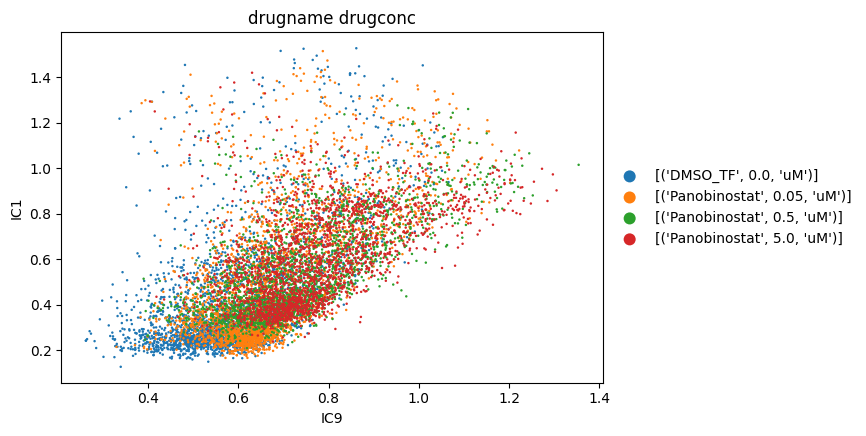

In [91]:
sc.pl.scatter(adatat1,x='IC9',y='IC1',color='drugname_drugconc')